In [1]:
# Import needed packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from PIL import Image
import cv2
import os
import random
from tqdm import tqdm
import pickle

In [2]:
# The base directory to images
# DATA_DIR = '../../../In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed PNG/'

# The size to transform the images to
IMG_SIZE = 50

# The range of clusters to test
MIN_K = 2
MAX_K = 40

### Load the data 

In [3]:
# Count the total number of images and create an empty array to hold the data
total_images = 0
for dir in os.listdir(DATA_DIR):
    image_list = os.listdir(DATA_DIR + dir)
    total_images += len(image_list)
print('Total Number of Images: ' + str(total_images))

# Empty array to hold the data
meltpools = np.zeros((total_images, IMG_SIZE*IMG_SIZE), dtype=np.uint8)
meltpools_name = list() # to hold the name of each meltpool for later use

Total Number of Images: 1033611


In [4]:
# Now load data into meltpool array
counts = 0
for dir in tqdm(os.listdir(DATA_DIR)):
    for meltpool_image in os.listdir(DATA_DIR + dir):
        im = cv2.imread(DATA_DIR + dir + '/' + meltpool_image, cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (IMG_SIZE, IMG_SIZE))
        imArray = np.array(im)

        meltpools[counts,:] = imArray.flatten()
        meltpools_name.append(DATA_DIR + dir + '/' + meltpool_image)
        counts += 1

# Save the melt pools so don't need to load every time
np.save("K_Means_Meltpools", meltpools)
np.save("K_Means_Meltpools_Name", meltpools_name)

100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [32:01<00:00,  7.72s/it]


In [3]:
# Load the preprocessed data
meltpools = np.load("K_Means_Meltpools.npy")
meltpools_name = np.load("K_Means_Meltpools_Name.npy")

### Perform K-Means Once as a Demonstration

In [4]:
mini_batch_kmeans_model = MiniBatchKMeans(n_clusters=2, n_init='auto', batch_size=2048) # do K-Means with mini batch for improved speed
kmeans_model = KMeans(n_clusters=2) # the standard K-Means

In [5]:
mini_batch_kmeans_model.fit(meltpools)

MiniBatchKMeans(batch_size=2048, n_clusters=2, n_init='auto')

In [7]:
clusters = mini_batch_kmeans_model.predict(meltpools)

In [14]:
centroids = mini_batch_kmeans_model.cluster_centers_

In [88]:
# Just saving for testing
np.save("clusters", clusters[2])
np.save("centroids", centroids[2])

In [4]:
clusters = np.load("clusters.npy")
centroids = np.load("centroids.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'clusters.npy'

### Run K-Means on range of Cluster Numbers 

In [5]:
centroids = dict()
clusters = dict()
for k in tqdm(range(MIN_K,MAX_K+1,1)):
    mini_batch_kmeans_model = MiniBatchKMeans(n_clusters=k, n_init='auto', batch_size=2048) # do K-Means with mini batch for improved speed
    mini_batch_kmeans_model.fit(meltpools)
    clusters[k] = mini_batch_kmeans_model.predict(meltpools)
    centroids[k] = mini_batch_kmeans_model.cluster_centers_

100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [09:47<00:00, 15.06s/it]


In [6]:
print(clusters)
print(centroids)

{2: array([1, 0, 0, ..., 0, 0, 0], dtype=int32), 3: array([1, 2, 2, ..., 0, 2, 2], dtype=int32), 4: array([1, 2, 0, ..., 0, 2, 2], dtype=int32), 5: array([1, 3, 0, ..., 4, 0, 0], dtype=int32), 6: array([3, 1, 2, ..., 4, 2, 2], dtype=int32), 7: array([3, 1, 2, ..., 4, 5, 5], dtype=int32), 8: array([0, 6, 4, ..., 3, 1, 1], dtype=int32), 9: array([1, 4, 0, ..., 7, 2, 2], dtype=int32), 10: array([2, 1, 5, ..., 0, 6, 9], dtype=int32), 11: array([ 1,  2,  7, ..., 10,  3,  3], dtype=int32), 12: array([ 1,  7,  9, ..., 10, 11, 11], dtype=int32), 13: array([ 1,  5,  0, ...,  7,  4, 11], dtype=int32), 14: array([ 0,  8, 10, ..., 12,  9,  9], dtype=int32), 15: array([ 2,  1, 12, ...,  6,  8,  8], dtype=int32), 16: array([ 2,  7,  1, ..., 12,  1,  1], dtype=int32), 17: array([1, 9, 7, ..., 3, 5, 2], dtype=int32), 18: array([ 2,  1,  4, ..., 12, 11, 11], dtype=int32), 19: array([ 2,  0,  9, ..., 14,  8,  1], dtype=int32), 20: array([ 1,  4, 11, ...,  8,  7,  2], dtype=int32), 21: array([ 1,  6, 18,

In [8]:
# Save the data
with open('centroids.pkl', 'wb') as fp:
    pickle.dump(centroids, fp)
    
with open('clusters.pkl', 'wb') as fp:
    pickle.dump(clusters, fp)

In [5]:
# Load the data
with open('centroids.pkl', 'rb') as fp:
    centroids = pickle.load(fp)
    
with open('clusters.pkl', 'rb') as fp:
    clusters = pickle.load(fp)

### Silhouette Analysis 

In [5]:
def Silhouette(data, labels, centers):
    num_data = data.shape[0]
    k = centers.shape[0]

    a = np.zeros((num_data, 1))
    b = np.zeros((num_data, 1))
    s = np.zeros((num_data, 1))
    for i in tqdm(range(num_data)):  # Iterate through each image
        cluster = labels[i]
        d = list()

        distance = np.zeros((num_data, 1))

        # Perform the calculation in batches for improved speed
        indx = 0
        for j in range(0, num_data, num_data):
            dist = np.square(data[indx:j,:] - data[i,:].astype('int32'))
            distance[indx:j] = np.sum(dist, axis=1, keepdims=True)
            indx = j
        dist = np.square(data[indx:, :] - data[i,:].astype('int32'))
        distance[indx:] = np.sum(dist, axis=1, keepdims=True)

        distance = np.sqrt(distance)
        for j in range(k):  # Iterate through each cluster
            cluster_j_indx = (labels == j)
            cluster_j_indx[i] = False
            # num_cluster_j_data = np.sum(cluster_j_indx)
            # cluster_j_data = data[cluster_j_indx, :]

            distances = distance[cluster_j_indx]
            if (j == cluster):  # Same cluster as image
                a[i] = np.mean(distances)
            else:  # a different cluster
                d.append(np.mean(distances))

        b[i] = np.min(np.array(d))

    denom = np.maximum(a, b)
    s = (b - a) / denom
    return np.mean(s)

In [6]:
sil = Silhouette(meltpools, clusters[2], centroids[2])
# Todo: Run on GPU to see how long will take

  0%|                                                                         | 29/1033611 [01:58<1171:07:30,  4.08s/it]


KeyboardInterrupt: 

In [ ]:
silhouettes = list()
for k in tqdm(range(MIN_K,MAX_K+1,1)):
    sil = silhouette_score(meltpools, clusters[k], metric='euclidean', sample_size=100000, random_state=25)
    silhouettes.append(sil)
np.save("silhouettes", np.array(silhouettes))

 47%|███████████████████████████████████████▎                                           | 9/19 [30:10<33:36, 201.63s/it]

In [ ]:
np.save("silhouettes_100000", np.array(silhouettes))

In [8]:
silhouettes = np.load("silhouettes.npy")

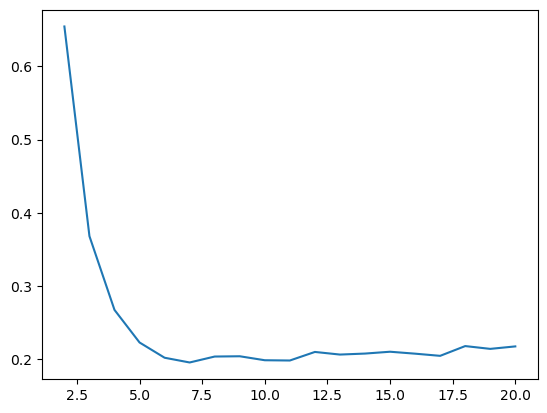

In [14]:
plt.plot(range(MIN_K,MAX_K+1,1), silhouettes)
plt.show()

### Analysis of Clusters

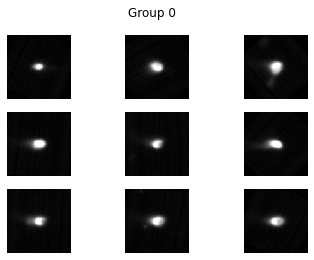

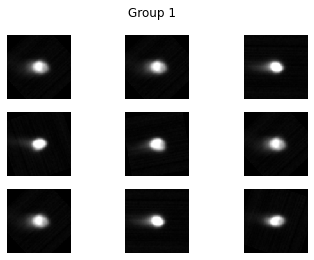

In [5]:
# Select Number of clusters to analyze:
k = 12
grid_size = 3

###############################
for ii in range(k):
    num = 0
    
    loc = (clusters[k] == ii).nonzero()
    
    fig, axs = plt.subplots(grid_size,grid_size)
    fig.suptitle('Class ' + str(ii))
    for jj in range(grid_size):
        for kk in range(grid_size):
            meltpool_class_ii = meltpools_name[loc[0][random.randint(0, len(loc[0])-1)]]
            im = cv2.imread(DATA_DIR + dir + '/' + meltpool_image, cv2.IMREAD_GRAYSCALE)
            imArray = np.array(im)
            axs[jj,kk].imshow(imArray, cmap='gray', interpolation='nearest')
            # axs[jj,kk].imshow(doughnutImages[:,:, loc[0][num]], cmap='gray', interpolation='nearest')
            # axs[jj,kk].imshow(doughnutImages[:,:, loc[0][random.randint(0, len(loc[0])-1)]], cmap='gray', interpolation='nearest')
            axs[jj,kk].axis('off')
            num += 1

In [11]:
loc = (clusters[12] == 0).nonzero()
loc

(array([    224,    1931,    1950, ..., 1033511, 1033546, 1033594]),)

In [14]:
loc[0][0]

224

In [12]:
meltpools_name[224]

'../../../In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed PNG/layer1/layer1_120.png'

C:\Users\satom\anaconda3\envs\meltpoolK_Means\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


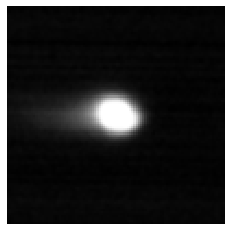

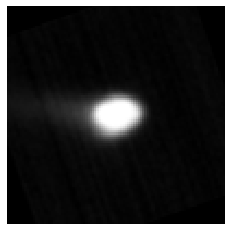

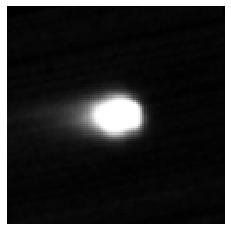

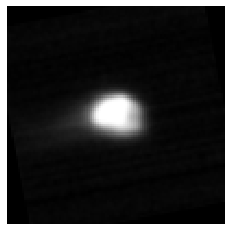

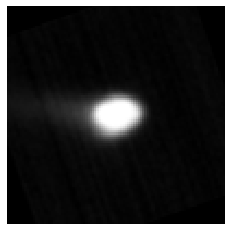

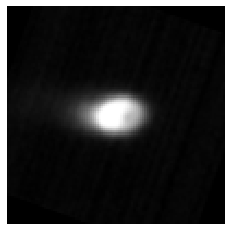

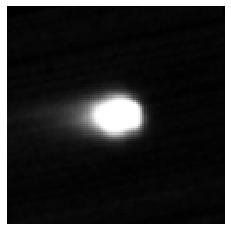

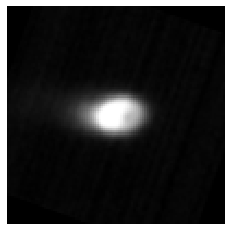

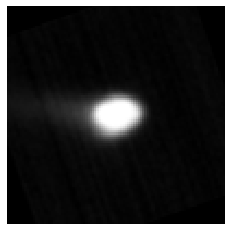

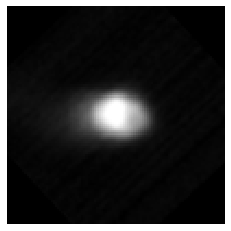

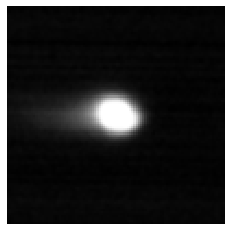

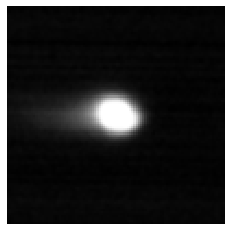

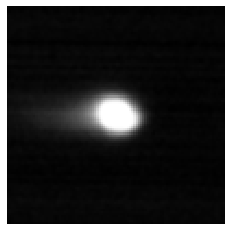

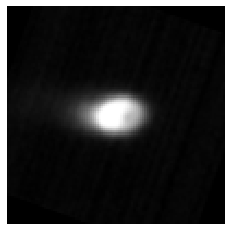

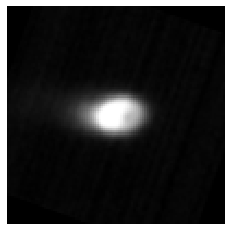

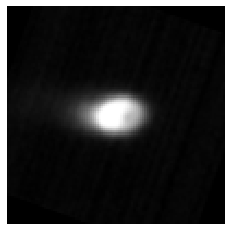

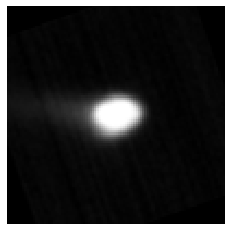

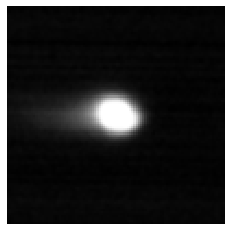

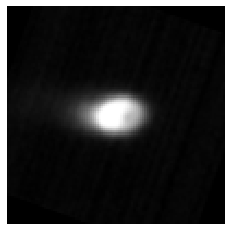

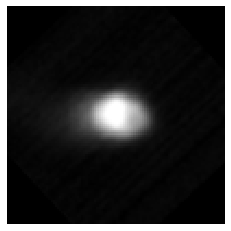

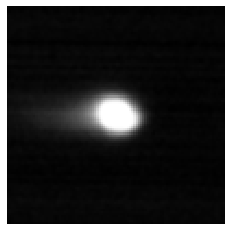

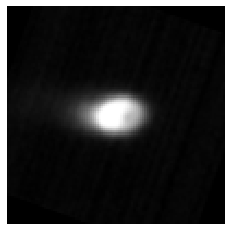

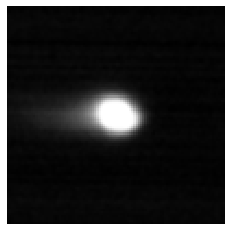

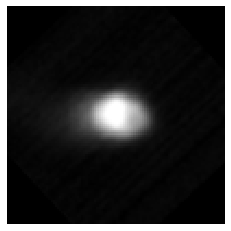

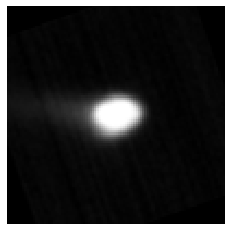

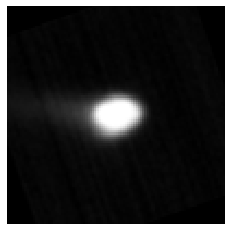

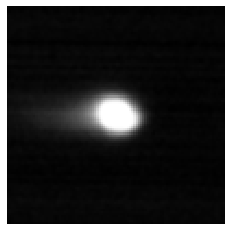

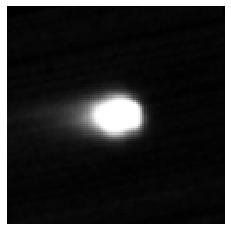

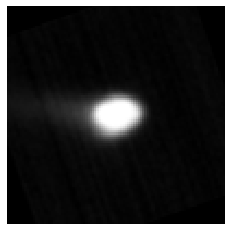

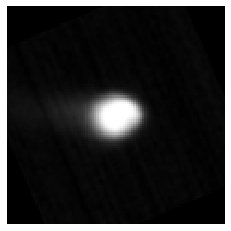

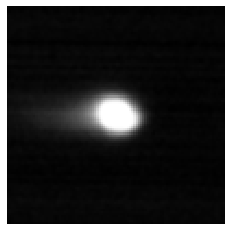

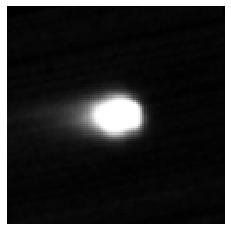

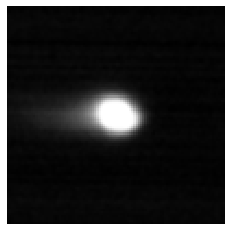

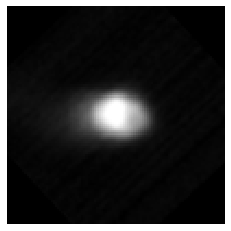

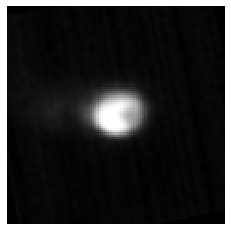

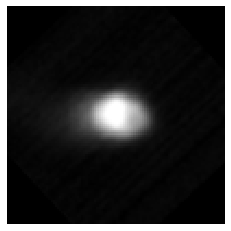

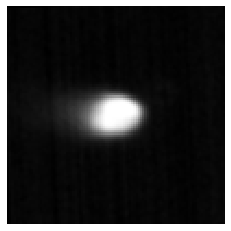

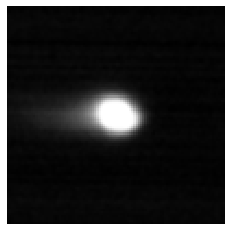

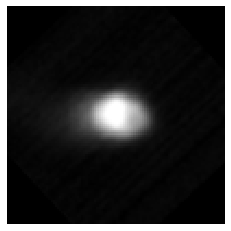

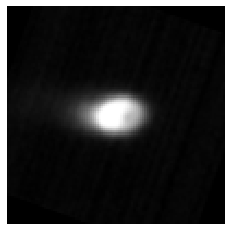

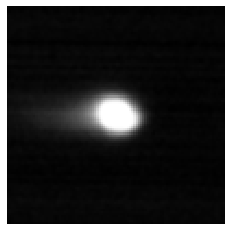

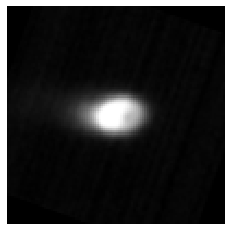

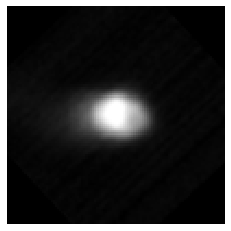

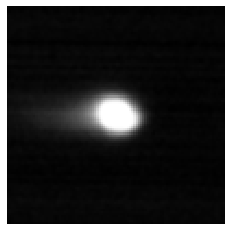

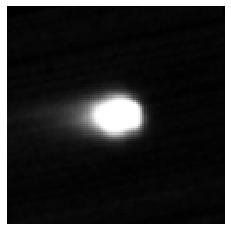

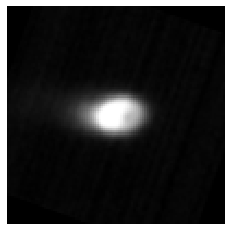

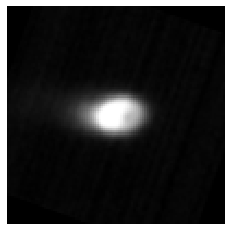

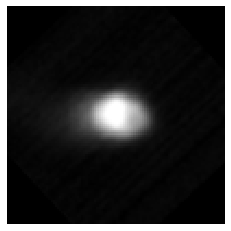

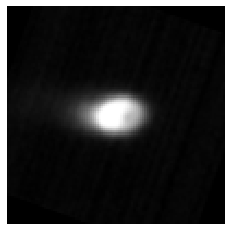

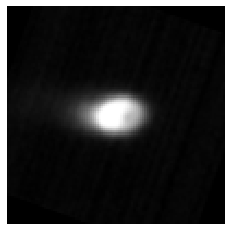

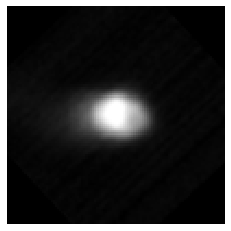

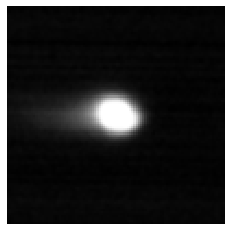

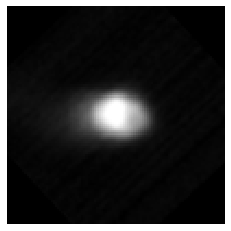

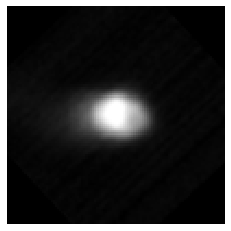

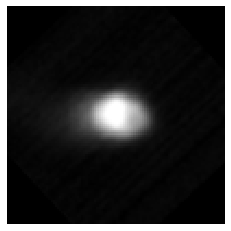

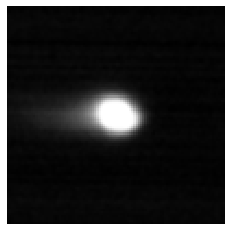

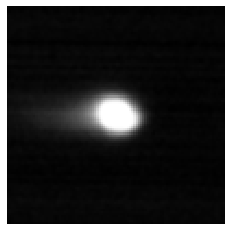

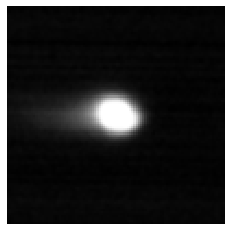

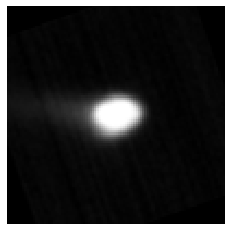

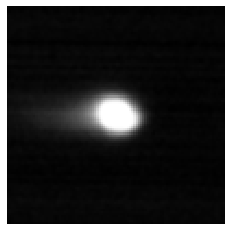

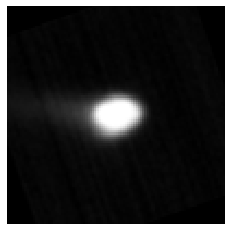

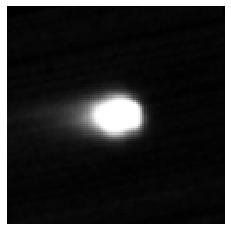

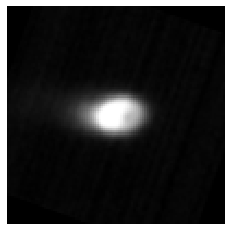

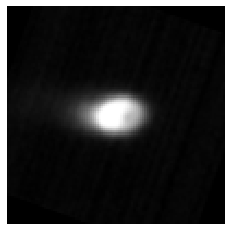

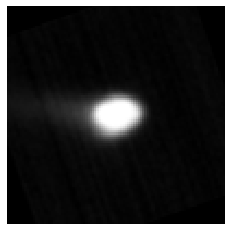

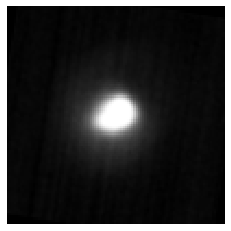

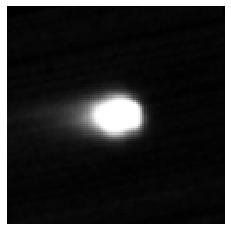

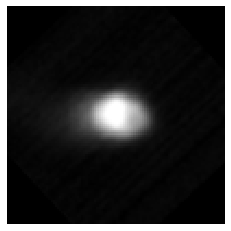

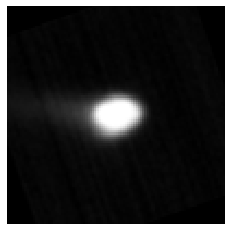

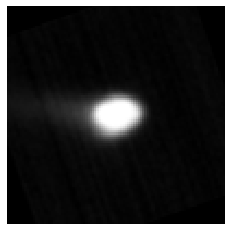

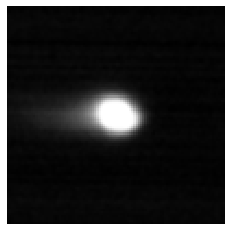

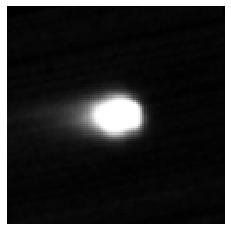

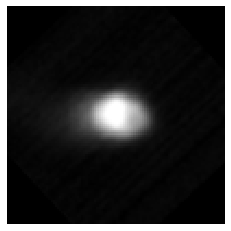

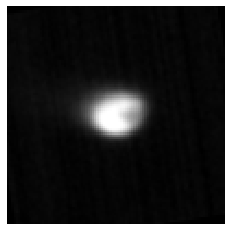

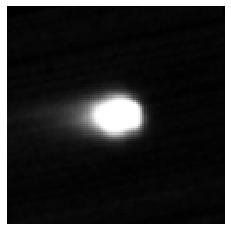

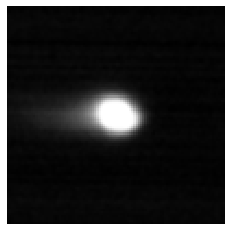

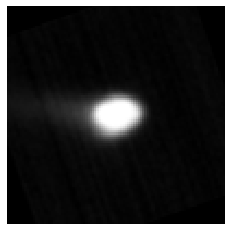

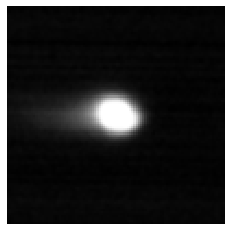

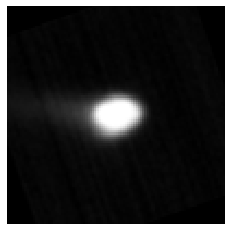

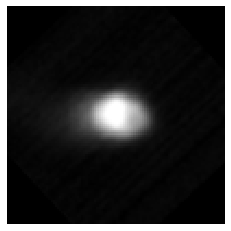

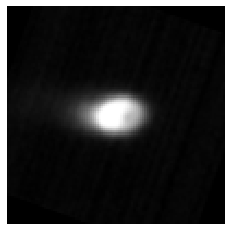

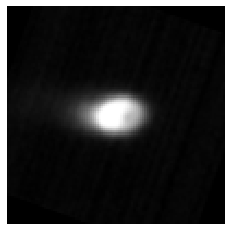

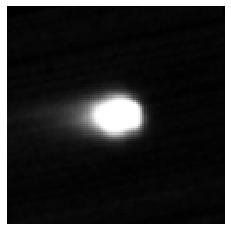

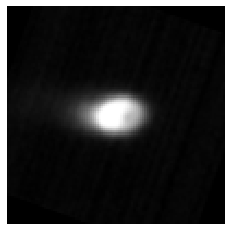

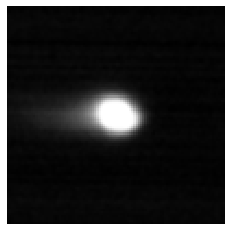

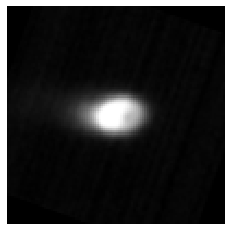

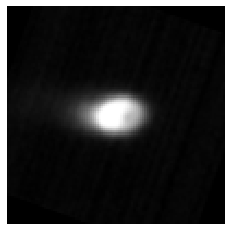

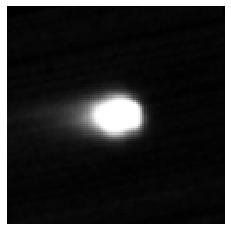

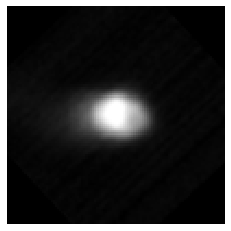

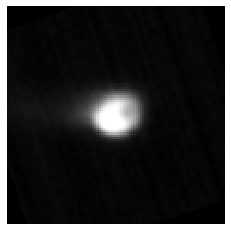

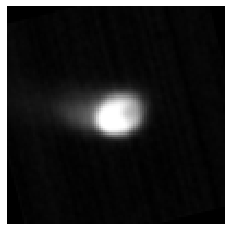

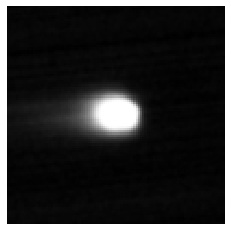

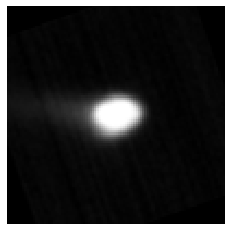

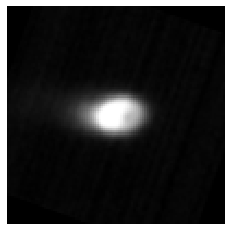

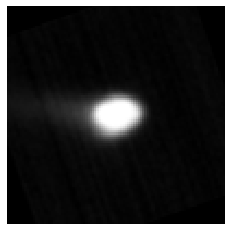

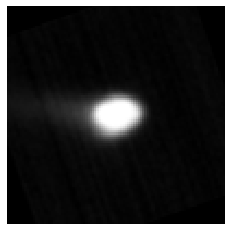

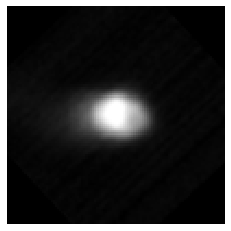

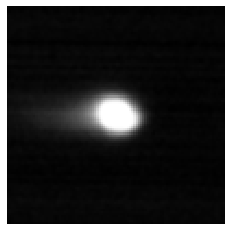

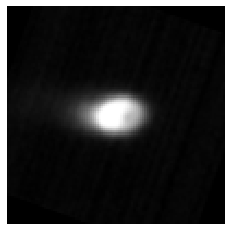

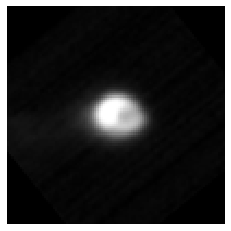

In [6]:
loc = (kmeansDoughnutClusters == 1).nonzero()
indx = random.sample(range(len(loc[0])-1), k=100)

for ii in range(100):
    plot = plt.figure(ii)
    plt.imshow(doughnutImages[:,:, loc[0][indx[ii]]], cmap='gray', interpolation='nearest')
    plt.axis('off')

In [7]:
loc = (kmeansDoughnutClusters == 1).nonzero()
len(loc[0])-1

22102

In [16]:
totalFeatures

36966

In [24]:
from numpy import genfromtxt

with open('In-situ Meas Data/Build Command Data/XYPT Commands/T500_3D_Scan_Strategies_fused_layer0012.csv', 'r') as f:
    my_data = genfromtxt(f, delimiter=',')
f.close()

In [53]:
indx = np.argwhere(my_data[:, 3] == 2)
xy_coord = my_data[indx, 0:3]
xy_coord = np.reshape(xy_coord, (5408,3))
np.shape(xy_coord)
xy_coord

array([[ 39.597776, -20.337329,  38.350446],
       [ 39.622843, -20.540661,  87.981675],
       [ 39.736869, -20.913641, 105.183704],
       ...,
       [ 39.740101, -20.924213, 165.771127],
       [ 39.66698 , -20.685032, 165.771127],
       [ 39.596859, -20.45567 , 153.025988]])

In [28]:
prediction = kmeansDoughnuts.predict(newMeltPools[12])

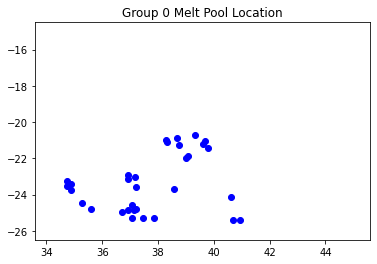

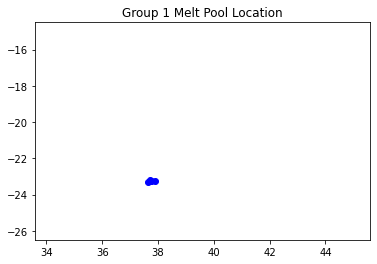

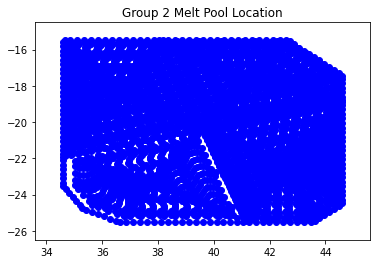

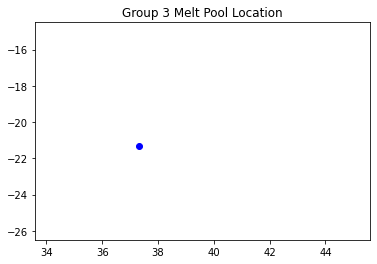

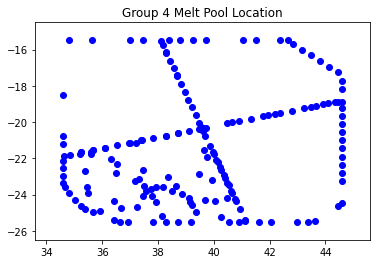

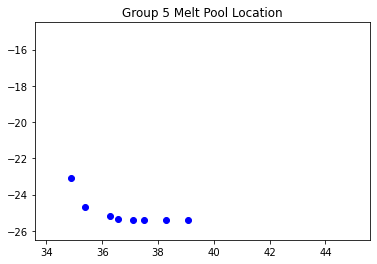

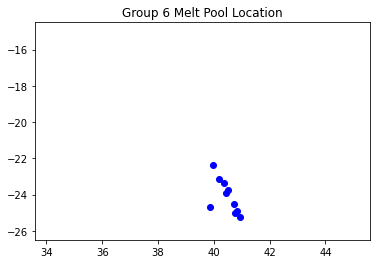

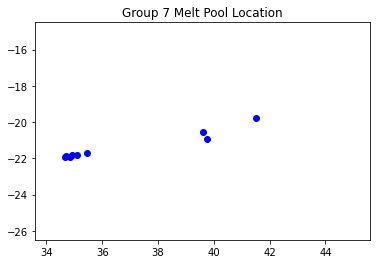

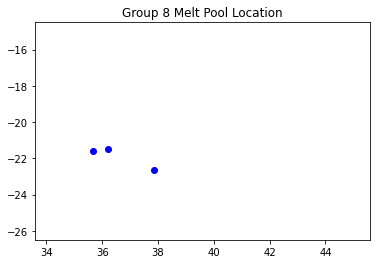

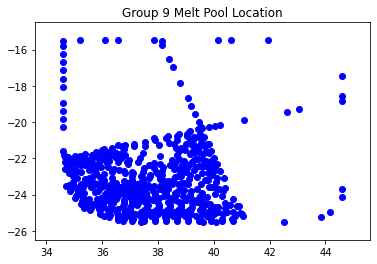

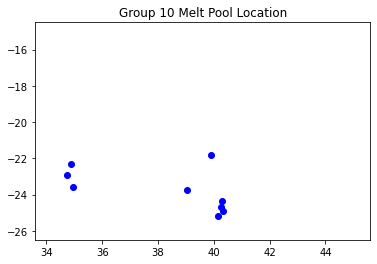

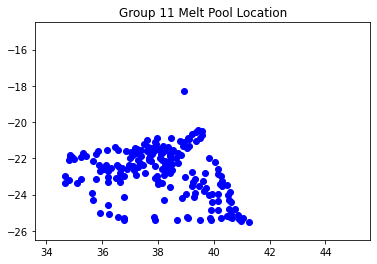

In [100]:
xmax = np.max(xy_coord[:,0])
xmin = np.min(xy_coord[:,0])
ymax = np.max(xy_coord[:,1])
ymin = np.min(xy_coord[:,1])

plt.scatter(xy_coord[np.argwhere(prediction == 0), 0],xy_coord[np.argwhere(prediction == 0), 1], c='b')
plt.title('Group 0 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()

plt.scatter(xy_coord[np.argwhere(prediction == 1), 0],xy_coord[np.argwhere(prediction == 1), 1], c='b')
plt.title('Group 1 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()

plt.scatter(xy_coord[np.argwhere(prediction == 2), 0],xy_coord[np.argwhere(prediction == 2), 1], c='b')
plt.title('Group 2 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()

plt.scatter(xy_coord[np.argwhere(prediction == 3), 0],xy_coord[np.argwhere(prediction == 3), 1], c='b')
plt.title('Group 3 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()

plt.scatter(xy_coord[np.argwhere(prediction == 4), 0],xy_coord[np.argwhere(prediction == 4), 1], c='b')
plt.title('Group 4 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()

plt.scatter(xy_coord[np.argwhere(prediction == 5), 0],xy_coord[np.argwhere(prediction == 5), 1], c='b')
plt.title('Group 5 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()

plt.scatter(xy_coord[np.argwhere(prediction == 6), 0],xy_coord[np.argwhere(prediction == 6), 1], c='b')
plt.title('Group 6 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()

plt.scatter(xy_coord[np.argwhere(prediction == 7)[1:-1], 0],xy_coord[np.argwhere(prediction == 7)[1:-1], 1], c='b')
plt.title('Group 7 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()

plt.scatter(xy_coord[np.argwhere(prediction == 8), 0],xy_coord[np.argwhere(prediction == 8), 1], c='b')
plt.title('Group 8 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()

plt.scatter(xy_coord[np.argwhere(prediction == 9), 0],xy_coord[np.argwhere(prediction == 9), 1], c='b')
plt.title('Group 9 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()

plt.scatter(xy_coord[np.argwhere(prediction == 10), 0],xy_coord[np.argwhere(prediction == 10), 1], c='b')
plt.title('Group 10 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()

plt.scatter(xy_coord[np.argwhere(prediction == 11), 0],xy_coord[np.argwhere(prediction == 11), 1], c='b')
plt.title('Group 11 Melt Pool Location')
ax = plt.gca()
ax.set_xlim([xmin-1, xmax+1])
ax.set_ylim([ymin-1, ymax+1])
plt.show()



In [ ]:
doughnutGroup1=8
doughnutGroup2=16
for ii in range(startLayer,endLayer+1):
    prediction = kmeansDoughnuts.predict(newMeltPools[ii])
    prediction1 = prediction == doughnutGroup1
    prediction2 = prediction == doughnutGroup2
    finalPrediction = prediction1 + prediction2
    np.savetxt(label[ii],finalPrediction,delimiter=',')
    label[ii].close()

In [ ]:
directory = 'Set 2/Melt Pool Camera TIFF Stacks Preprocessed/layer'

newMeltPools = {}
for ii in range(60, 70):
    print(ii)
    layerDir = directory + str(ii)
    dirListing = os.listdir(layerDir)
    meltPools = np.zeros((len(dirListing), 100*100))
    counts = 0
    for jj in range(len(dirListing)):
        im = Image.open(layerDir + '/layer' + str(ii) + '_' + str(jj+1) + '.tif')
        imArray = np.array(im)
        im.close()
        if len(imArray) == 100 and len(imArray[0]) == 100:
            meltPools[counts,:] = imArray.flatten() # Flatten the array to get one dimension of data
            counts += 1
        else:
            counts +=1
    newMeltPools[ii] = meltPools

In [ ]:
doughnutGroup1=
doughnutGroup2=17
doughnutGroup3=50

for ii in range(10,20):
    prediction = kmeansDoughnuts.predict(newMeltPools[ii])
    print(str(ii) + ':' + str((prediction == doughnutGroup1).nonzero()[0]) + ', ' + str((prediction == doughnutGroup2).nonzero()[0]) + ', ' + str((prediction == doughnutGroup3).nonzero()[0]))

In [ ]:
# Change float to string in csv file 
import csv
import os
import numpy as np
from numpy import genfromtxt

startLayer = 13
endLayer = 13

label = {}
label2 = {}
for ii in range(startLayer, endLayer+1,1):
    directory = 'In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed/layer' + str(ii) + '/lables.csv'
    directory2 = 'In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed/layer' + str(ii) + '/lables2.csv'
    my_data = genfromtxt(directory, delimiter=',')
    
    label = open(directory, 'w')
    label.truncate(0)
    np.savetxt(label,my_data.astype(int),delimiter=',', fmt="%s")
    label.close()
    
            

In [ ]:
import csv
import os

# Create lables csv in proper format
startLayer = 13
endLayer = 13

label = {}
label2 = {}
for ii in range(startLayer, endLayer+1,1):
    directory = 'In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed/layer' + str(ii) + '/lables.csv'
    directory2 = 'In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed/layer' + str(ii) + '/lables2.csv'
    with open(directory, 'r') as f:
        reader = csv.reader(f, delimiter = ',')
        with open(directory2, 'w', newline='') as newf:
            for jj in range(len(os.listdir('In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed/layer' + str(ii)))-2):
                writer = csv.DictWriter(newf, fieldnames = ['file', 'label'])
                writer.writerow({'file': 'layer'+ str(ii) + '_' + str(jj+1) + '.tif', 'label': next(reader)[0]})
            

In [ ]:
import csv
import os
import numpy as np
from numpy import genfromtxt
import shutil
import random

startLayer = 151
endLayer = 250

trainDir = 'In-situ Meas Data/classifierData/train/'
valDir = 'In-situ Meas Data/classifierData/val/'

for ii in range(startLayer, endLayer+1,1):
    directory = 'In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed/layer' + str(ii) + '/lables.csv'
    directory2 = 'In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed/layer' + str(ii) + '/lables2.csv'
       
    my_data = genfromtxt(directory, delimiter=',')
    for jj in range(np.size(my_data)):
        imDir = 'In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed/layer' + str(ii) + '/layer' + str(ii) + '_' + str(jj+1) + '.tif'
        if my_data[jj] == 0:
            if random.randint(1,10) <= 2:
                shutil.copy(imDir, valDir + 'nonDoughnut')
            else:
                shutil.copy(imDir, trainDir + 'nonDoughnut')    
        else:
            if random.randint(1,10) <= 2:
                shutil.copy(imDir, valDir + 'doughnut')
            else:
                shutil.copy(imDir, trainDir + 'doughnut')

In [ ]:
import csv
import os
import numpy as np
from numpy import genfromtxt

directory = 'In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed/layer12/lables.csv'
my_data = genfromtxt(directory, delimiter=',')

In [ ]:
import random

random.randint(1,10)

In [ ]:
import os
from PIL import Image
import glob

dirIn = 'In-situ Meas Data\classifierData\train\doughnut'
dirOut = 'In-situ Meas Data\classifierData\train\nonDoughnut'

counts = 0
for file in directory:
    

In [ ]:
import os
from PIL import Image
import glob

In [ ]:
im = Image.open('In-situ Meas Data/classifierData/train/doughnut/layer2_13.tif')

In [ ]:
newIm = im.thumbnail(im.size)

In [ ]:
newIm.save('In-situ Meas Data/classifierData3/train/doughnut/doughnut1.jpg', "JPEG", quality=100)